In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import os
import random

In [93]:
# Default device plus free memory
torch.cuda.empty_cache()
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [94]:
""" # Modify ResNet-18 for MNIST
model = resnet18(pretrained=False)
# Change the input layer to accept grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Adjust the final layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Load the saved state_dict
model.load_state_dict(torch.load('./Models/resnet18_mnist.pth'))

# Move model to device and set to evaluation mode
model = model.to(device).eval() """

" # Modify ResNet-18 for MNIST\nmodel = resnet18(pretrained=False)\n# Change the input layer to accept grayscale images\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n# Adjust the final layer to output 10 classes\nmodel.fc = nn.Linear(model.fc.in_features, 10)\n\n# Load the saved state_dict\nmodel.load_state_dict(torch.load('./Models/resnet18_mnist.pth'))\n\n# Move model to device and set to evaluation mode\nmodel = model.to(device).eval() "

In [95]:
class Net(nn.Module):
    def __init__(self, chanels, kernel_size):
        super(Net, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(1, chanels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(chanels)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        # Second block
        self.conv2 = nn.Conv2d(chanels, 2 * chanels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(2 * chanels)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # Third block
        self.conv3 = nn.Conv2d(2*chanels, 4 * chanels, kernel_size, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(4 * chanels)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        
        # Fourth block (no pooling after this)
        self.conv4 = nn.Conv2d(4*chanels, 8 * chanels, kernel_size, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(8 * chanels)
        self.relu4 = nn.ReLU()
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(8*chanels, 128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.relu4(self.bn4(self.conv4(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.drop1(F.relu(self.fc1(x)))
        x = self.fc2(x) 
        
        return x

In [96]:
# Instantiate the model
chanels = 32
kernel_size = 3
model = Net(chanels, kernel_size)

# Load the weights
model.load_state_dict(torch.load("./Models/custom_cnn_mnist.pth"))
model.eval()  # Set the model to evaluation mode

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU

In [97]:
# Apply resize and normalization to the images
transform = transforms.Compose([
    # transforms.Resize((224, 224)), used for resnet18
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the MNIST dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)


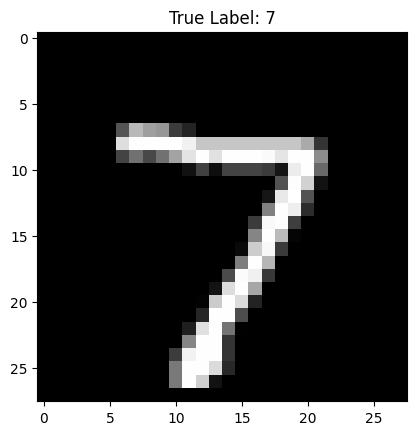

In [98]:
# Fetch an image and its label
image, label = test_dataset[0]  # This fetches the first image from the test set

plt.imshow(image.squeeze(), cmap='gray')  # Since it's a grayscale image
plt.title(f"True Label: {label}")
plt.show()

In [99]:
# Add batch dimension and run the model
with torch.no_grad():
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    output = model(image)
    predicted_label = torch.argmax(output).item()
    probabilities = F.softmax(output, dim=1)  # Apply softmax to get the probabilities
    prediction_score = probabilities[0][predicted_label].item()  # Confidence score for the predicted label

print(f"Predicted Label: {predicted_label}")
print(f"Confidence Score for the Predicted Label: {prediction_score:.4f}")
print(f"Probability Distribution over Classes: {probabilities[0].tolist()}")

Predicted Label: 7
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [4.783697309801438e-12, 9.887475727055062e-08, 1.3659799513732196e-08, 1.662241366773287e-08, 7.697855131105769e-10, 6.547402203738173e-11, 1.9011125952563684e-14, 0.9999998807907104, 6.377480574887295e-12, 5.7158761279652026e-08]


In [100]:
pred_label_idx = predicted_label
transformed_img = image

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(transformed_img, target=predicted_label, n_steps=200)

In [101]:
print(attributions_ig.squeeze().cpu().detach().numpy().shape)
transformed_img.squeeze().cpu().detach().numpy().shape

(28, 28)


(28, 28)

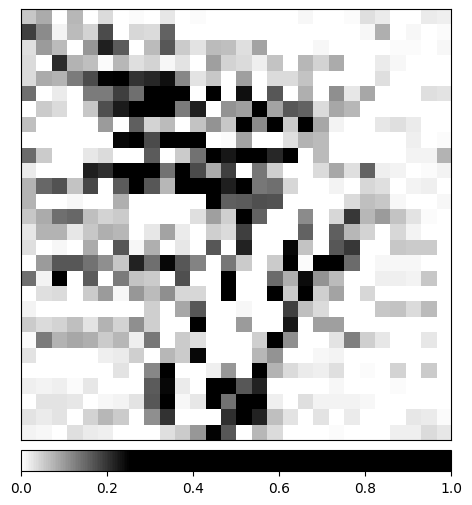

In [102]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'),
     (0.25, '#000000'),
     (1, '#000000')],
    N=256
)

attr_reshaped = attributions_ig.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
img_reshaped = transformed_img.squeeze().cpu().detach().numpy().reshape(28, 28, 1)

_ = viz.visualize_image_attr(attr_reshaped,
                             img_reshaped,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)


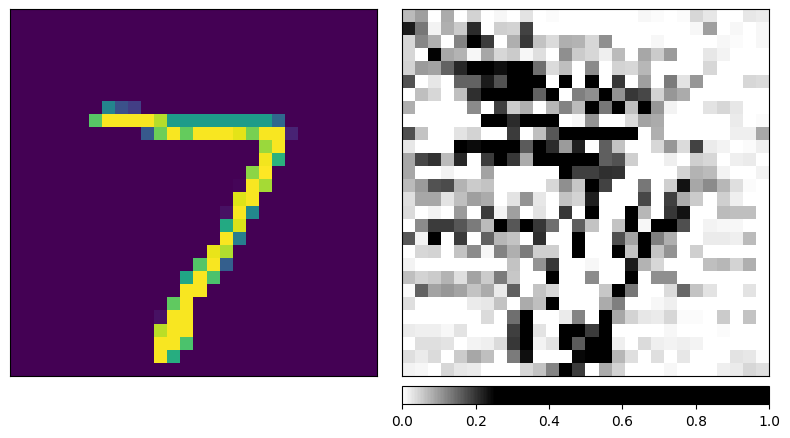

In [103]:
noise_tunnel = NoiseTunnel(integrated_gradients)
input = image

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label)
_ = viz.visualize_image_attr_multiple(attr_reshaped,
                                      img_reshaped,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

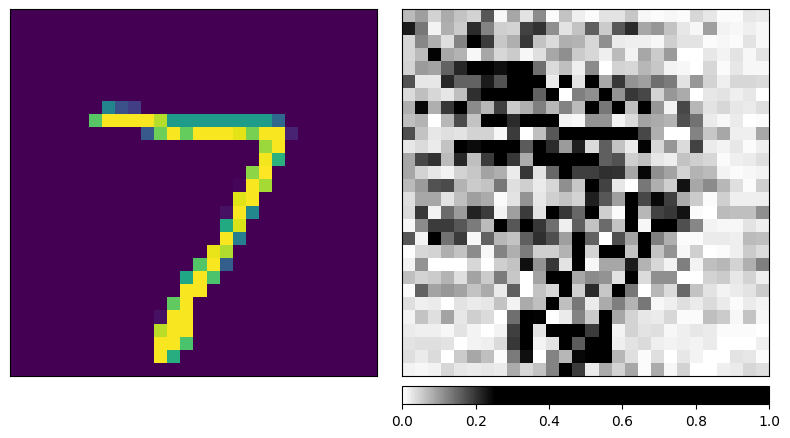

In [104]:
torch.manual_seed(0)
np.random.seed(0)
input = image

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(attr_reshaped,
                                      img_reshaped,
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [105]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (1, 1, 1),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,2, 2),
                                       baselines=0)


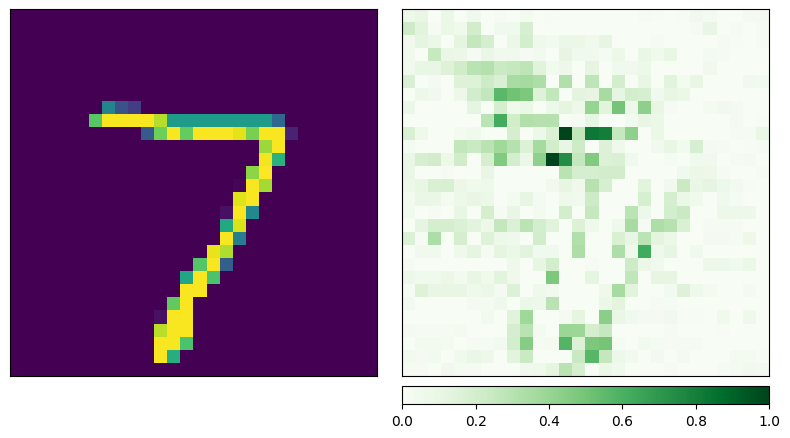

In [106]:
_ = viz.visualize_image_attr_multiple(attr_reshaped,
                                      img_reshaped,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

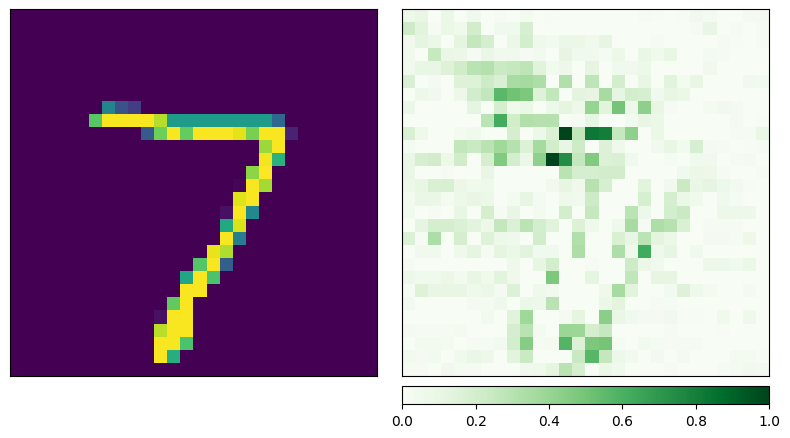

In [107]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (1, 1, 1),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,2, 2),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(attr_reshaped,
                                      img_reshaped,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )